In [1]:
import datetime

import h5py
import nengo
import numpy as np
import seaborn as sns
import pandas as pd
from nengo.utils.numpy import rmse
import scipy
from scipy import interpolate
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

from constants import *
from process import d3_scale

In [2]:
period = 0.5
run_num = 10


def make_sin(freq):
    per = 2 * np.pi * freq
    
    def sin_targ(t):
        return np.sin(per*t)
    return sin_targ


def make_cos(freq):
    per = 2 * np.pi * freq
    
    def cos_targ(t):
        return 0.5*np.cos(freq*t)
    return cos_targ

def bump_func(t):
    return 1 if t < 0.1 else 0

In [3]:
# just for initial analysis, I'll probably want to add more frequency points later
freq_list = [2, 6, 10, 15, 20]
targ_funcs = []
for f in freq_list:
    targ_funcs.append(make_sin(f))

In [4]:
from attractor_dmp_net import make_attrac_net


def run_ad(target_func, seed=0):
    pre_dat = target_func(np.linspace(0, period, 100))
    xv = np.linspace(-np.pi, np.pi, pre_dat.shape[0])
    proc_func = interpolate.interp1d(xv, pre_dat)
    
    with nengo.Network() as ad_model:
        bump = nengo.Node(bump_func)
    
        osc = nengo.Network()
        osc.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        osc.config[nengo.Ensemble].seed = seed
        nengo.networks.Oscillator(0.1, 4*np.pi, 300, net=osc)
    
        dmp, conn_func = make_attrac_net(proc_func, 300, seed=seed)
    
        nengo.Connection(bump, osc.ensemble[0])
        nengo.Connection(osc.ensemble, dmp.input, function=conn_func)
    
        p_out = nengo.Probe(dmp.output, synapse=0.01)
    
    with nengo.Simulator(ad_model) as ad_sim:
        ad_sim.run(4*period)
        
    return ad_sim.data[p_out][int(2*period/dt):]

In [5]:
ad_res = []
run_num = 10

for t_i, targ in enumerate(targ_funcs):
    for n in range(run_num):
        # hardcoded for 1D
        tmp_res = d3_scale(run_ad(targ, seed=n))[:, 0]
        if n == 0:
            ref_res = targ(np.arange(0, tmp_res.shape[0]*dt, dt))
        
        lag = np.argmax(signal.correlate(ref_res, tmp_res))
        ad_res.append((np.roll(tmp_res, shift=lag), freq_list[t_i], "Attract DMP",) )

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01

In [6]:
dar = pd.DataFrame(ad_res, columns=["Result", "Signal Frequency", "Approach"])

(50,)


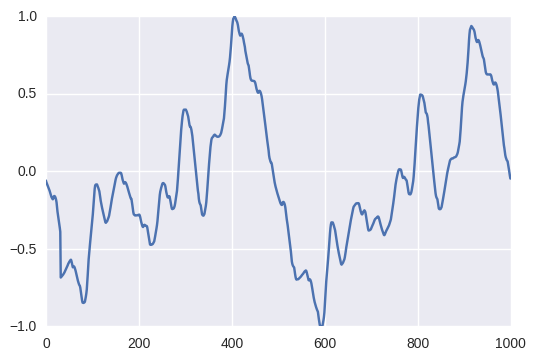

In [8]:
print(dar["Result"].shape)
plt.plot(dar["Result"][49])

In [8]:
rmse_vals = np.zeros(run_num * len(targ_funcs))

for t_i, targ in enumerate(targ_funcs):
    ref_res = targ(np.arange(0, dar["Result"][t_i*10].shape[0]*dt, dt)) 
    for n in range(run_num):
        rmse_vals[t_i*10+n] = rmse(ref_res, dar["Result"][t_i*10+n])
dar["RMSE"] = rmse_vals

In [9]:
#hdf.put('dmp_attract_res', dar, format='table')
dar.to_hdf("ad_res_final",'dmp_attract_res')

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Result', 'Approach']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [4]:
dar = pd.read_hdf("ad_res_final", "dmp_attract_res")

In [5]:
# load the matlab results
mat_rmse = scipy.io.loadmat("results/rmseVals_mf.mat")['rmseVals']
mat_val = scipy.io.loadmat("results/c_res_mf.mat")['c_res']
print(mat_rmse.shape)
print(mat_val.shape)

(5, 10)
(5, 10, 1501)


In [9]:
mat_res = []
for fi, freq in enumerate(freq_list):
    for n in range(run_num):
        mat_res.append((mat_val[fi, n], freq, "Conceptor", mat_rmse[fi, n]))

In [10]:
mar = pd.DataFrame(mat_res, columns=["Result", "Signal Frequency", "Approach", "RMSE"])

In [4]:
ddr_list = []
ddr_freq = ["2hz", "6hz", "10hz_2", "15hz", "20hz"]

for fr in ddr_freq:
    ddr_list.append(pd.read_hdf("direct_%s.h5" %(fr), key="/rmse"))
    with h5py.File("direct_%s.h5" %(fr), "r") as hf:
        res = np.array(hf["result"])
    ddr_list[-1]["Result"] = list(res)

In [5]:
ddr = pd.concat(ddr_list, ignore_index=True)
print(ddr.shape)

(50, 4)


In [13]:
res_df = pd.concat((ddr, dar, mar), ignore_index=True)
print(res_df.shape)

(150, 4)


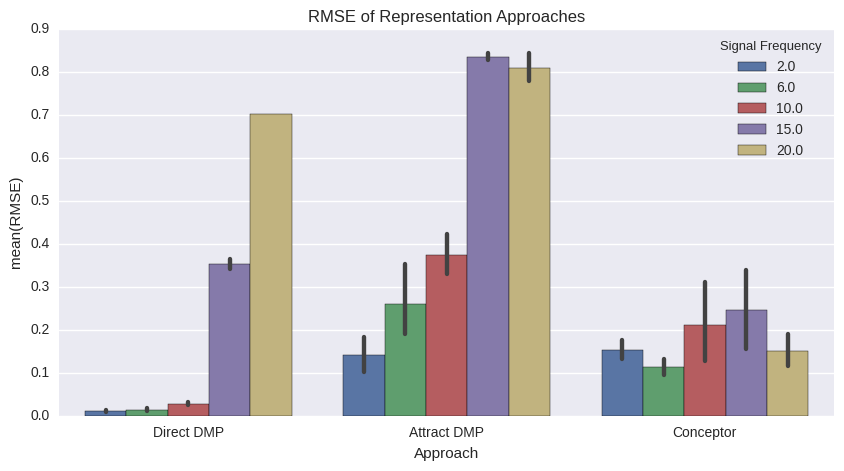

In [25]:
# plot all the results using sexy Seaborne
sns.plt.figure(figsize=(10,5))
sns.barplot('Approach', 'RMSE', hue='Signal Frequency', data=res_df)
sns.plt.title("RMSE of Representation Approaches")
sns.plt.savefig("compbar.pdf", format="pdf")

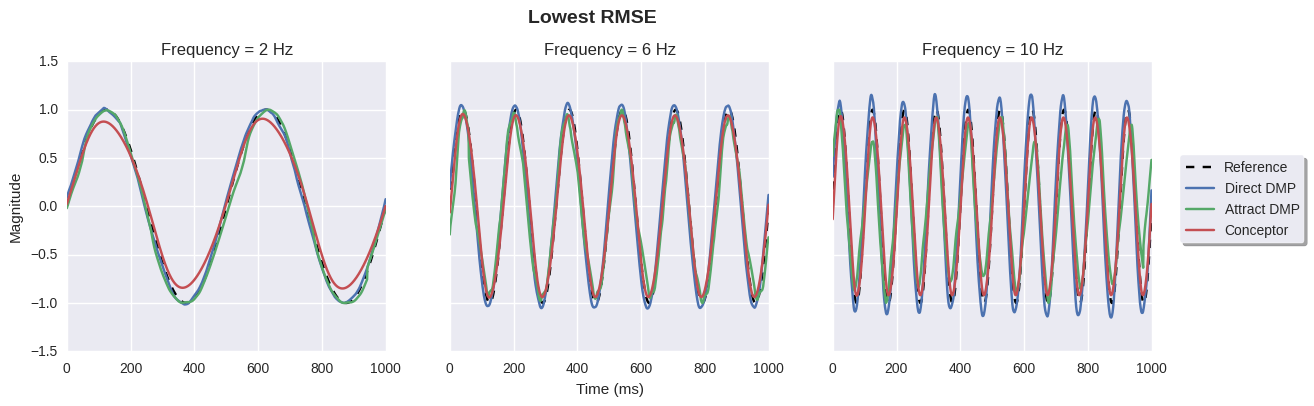

In [24]:
# plot the example with the lowest RMSE of each approach at each frequency
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14,4))
axes = list(axes.flatten())

for fi, freq in enumerate(freq_list[:3]):
    axes[fi].plot(targ_funcs[fi](np.arange(0, 1000*dt, dt)), color="black", linestyle="--")

    for app in res_df.Approach.unique():
        a_view = res_df[(res_df['Approach'] == app) & (res_df['Signal Frequency'] == freq)]['RMSE']
        axes[fi].plot(res_df.ix[a_view.idxmin()]['Result'][:1000])
    
    axes[fi].set_title("Frequency = %s Hz" %(freq,))

plt.legend(["Reference"] + list(res_df.Approach.unique()), bbox_to_anchor=(1.5, 0.7),
           frameon=True, fancybox=True, shadow=True)
fig.suptitle("Lowest RMSE", fontsize=14, fontweight="bold")
fig.subplots_adjust(top=0.85)
axes[0].set_ylabel("Magnitude")
axes[1].set_xlabel("Time (ms)")
plt.savefig("compwave_low.pdf", format="pdf", bbox_inches='tight')

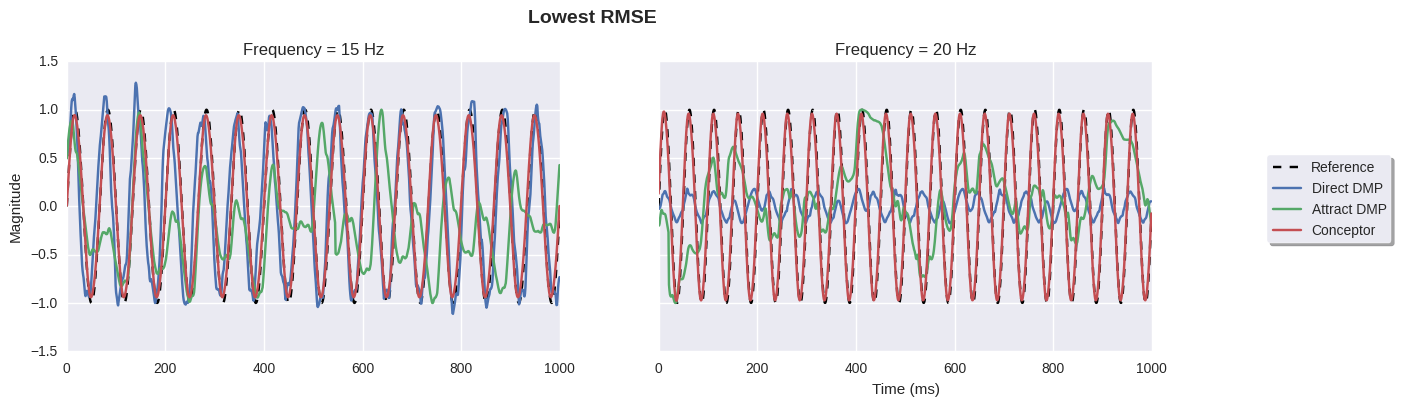

In [25]:
# plot the example with the lowest RMSE of each approach at each frequency
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(14,4))
axes = list(axes.flatten())

for fi, freq in enumerate(freq_list[3:]):
    axes[fi].plot(targ_funcs[3+fi](np.arange(0, 1000*dt, dt)), color="black", linestyle="--")

    for app in res_df.Approach.unique():
        a_view = res_df[(res_df['Approach'] == app) & (res_df['Signal Frequency'] == freq)]['RMSE']
        axes[fi].plot(res_df.ix[a_view.idxmin()]['Result'][:1000])
    
    axes[fi].set_title("Frequency = %s Hz" %(freq,))

plt.legend(["Reference"] + list(res_df.Approach.unique()), bbox_to_anchor=(1.5, 0.7),
           frameon=True, fancybox=True, shadow=True)
fig.suptitle("Lowest RMSE", fontsize=14, fontweight="bold")
fig.subplots_adjust(top=0.85)
axes[0].set_ylabel("Magnitude")
axes[1].set_xlabel("Time (ms)")
plt.savefig("compwave_high.pdf", format="pdf", bbox_inches='tight')

In [6]:
ddr

,RMSE,Signal Frequency,Approach,Result
0,0.010740,2.0,Direct DMP,"[0.0980036740788, 0.108476562774, 0.1189454496..."
1,0.010077,2.0,Direct DMP,"[0.0789042819257, 0.0900242354835, 0.100985705..."
2,0.012927,2.0,Direct DMP,"[0.0823592020361, 0.093215308823, 0.1039749899..."
3,0.009794,2.0,Direct DMP,"[0.0577210442406, 0.0688291042883, 0.080594102..."
4,0.012509,2.0,Direct DMP,"[0.0742807675728, 0.0866466139244, 0.099032052..."
5,0.012265,2.0,Direct DMP,"[0.0976040501592, 0.107557855841, 0.1175263699..."
6,0.017808,2.0,Direct DMP,"[0.084258945562, 0.0980730053181, 0.1117850887..."
7,0.013394,2.0,Direct DMP,"[0.0692573909202, 0.0830522428084, 0.096069766..."
8,0.008605,2.0,Direct DMP,"[0.0911969229954, 0.102372092282, 0.1149825759..."
9,0.012049,2.0,Direct DMP,"[0.0712913553453, 0.0807404654662, 0.090116625..."
